In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Colab_Dataset/Dataset/


test  train  val


In [3]:
# ✅ Step 1 — Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Step 2 — Verify dataset path
!ls /content/drive/MyDrive/Colab_Dataset/Dataset/

# ✅ Step 3 — Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight

# ✅ Step 4 — Define paths
train_dir = "/content/drive/MyDrive/Colab_Dataset/Dataset/train"
val_dir   = "/content/drive/MyDrive/Colab_Dataset/Dataset/val"
test_dir  = "/content/drive/MyDrive/Colab_Dataset/Dataset/test"

# ✅ Step 5 — Load datasets
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("✅ Class Names:", class_names)

# ✅ Step 6 — Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test  train  val
Found 2443 files belonging to 2 classes.
Found 524 files belonging to 2 classes.
Found 528 files belonging to 2 classes.
✅ Class Names: ['Non_Tilapia', 'Tilapia']


In [4]:
# ✅ Step 7 — Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])

# ✅ Step 8 — Build EfficientNetB3 model
base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze base for transfer learning

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# ✅ Step 9 — Compile model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ✅ Step 10 — Compute class weights
labels = np.concatenate([y for x, y in train_ds], axis=0)
y_int = np.argmax(labels, axis=1)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_int),
                                     y=y_int)
class_weights = dict(enumerate(class_weights))
print("📊 Class Weights:", class_weights)

# ✅ Step 11 — Train base (frozen) model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

# ✅ Step 12 — Fine-tune top layers
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2  # unfreeze last half of layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

# ✅ Step 13 — Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n🎯 Final Test Accuracy: {test_acc*100:.2f}%")

# ✅ Step 14 — Save the trained model
model.save("/content/tilapia_best_model.keras")
print("✅ Model saved as /content/tilapia_best_model.keras")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
📊 Class Weights: {0: np.float64(1.0061779242174629), 1: np.float64(0.9938974776240846)}
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6688 - loss: 0.5920 - val_accuracy: 0.8645 - val_loss: 0.3240
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.8504 - loss: 0.3459 - val_accuracy: 0.8950 - val_loss: 0.2572
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8957 - loss: 0.2689 - val_accuracy: 0.9332 - val_loss: 0.2165
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.8980 - loss: 0.2596 - val_accuracy: 0.9427 - val_loss: 0.1940
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.9207 - loss: 0.2219 - val_accuracy: 0.9427 - val_loss: 0.1857
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.9060 - loss: 0.2320 - val_accuracy: 0.9332 - val_loss: 0.1785
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 201ms/step - accuracy: 0.9232 - loss: 0.2146 - 

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_101472]

In [5]:
import os
from PIL import Image

def clean_dataset(directory):
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    removed = 0
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            if not file.lower().endswith(valid_exts):
                os.remove(path)
                removed += 1
            else:
                try:
                    img = Image.open(path)
                    img.verify()  # verify image integrity
                except Exception:
                    os.remove(path)
                    removed += 1
    print(f"🧹 Cleaned {removed} invalid/corrupt files in: {directory}")

clean_dataset("/content/drive/MyDrive/Colab_Dataset/Dataset/train")
clean_dataset("/content/drive/MyDrive/Colab_Dataset/Dataset/val")
clean_dataset("/content/drive/MyDrive/Colab_Dataset/Dataset/test")


🧹 Cleaned 0 invalid/corrupt files in: /content/drive/MyDrive/Colab_Dataset/Dataset/train
🧹 Cleaned 0 invalid/corrupt files in: /content/drive/MyDrive/Colab_Dataset/Dataset/val
🧹 Cleaned 0 invalid/corrupt files in: /content/drive/MyDrive/Colab_Dataset/Dataset/test


In [6]:
import os

def deep_clean_hidden_files(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for f in files:
            path = os.path.join(root, f)
            if f.startswith('.') or os.path.getsize(path) == 0:
                os.remove(path)
                removed += 1
    print(f"🧩 Removed {removed} hidden/empty files from: {directory}")

deep_clean_hidden_files("/content/drive/MyDrive/Colab_Dataset/Dataset/train")
deep_clean_hidden_files("/content/drive/MyDrive/Colab_Dataset/Dataset/val")
deep_clean_hidden_files("/content/drive/MyDrive/Colab_Dataset/Dataset/test")


🧩 Removed 0 hidden/empty files from: /content/drive/MyDrive/Colab_Dataset/Dataset/train
🧩 Removed 0 hidden/empty files from: /content/drive/MyDrive/Colab_Dataset/Dataset/val
🧩 Removed 0 hidden/empty files from: /content/drive/MyDrive/Colab_Dataset/Dataset/test


In [8]:
!ls -lh /content | grep .keras
!ls -lh /content/drive/MyDrive/Colab_Dataset | grep .keras



In [9]:
model.save("/content/tilapia_best_model.keras")
print("✅ Model re-saved at /content/tilapia_best_model.keras")


✅ Model re-saved at /content/tilapia_best_model.keras


In [10]:
model = tf.keras.models.load_model("/content/tilapia_best_model.keras")


In [11]:
# ✅ Step 15 — Gradio Web App for Fish Prediction
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Load your trained model ---
model = tf.keras.models.load_model("/content/tilapia_best_model.keras")

# --- Define class names ---
class_names = ["Non_Tilapia", "Tilapia"]

# --- Prediction function ---
def predict_fish(img):
    img = img.convert("RGB").resize((224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    preds = model(x, training=False).numpy()[0]
    probs = tf.nn.softmax(preds).numpy()
    pred_idx = np.argmax(probs)
    pred_label = class_names[pred_idx]
    confidence = probs[pred_idx] * 100
    return {class_names[0]: float(probs[0]), class_names[1]: float(probs[1])}, f"✅ Prediction: {pred_label} ({confidence:.2f}% confidence)"

# --- Build Gradio Interface ---
interface = gr.Interface(
    fn=predict_fish,
    inputs=gr.Image(type="pil", label="Upload Fish Image"),
    outputs=[
        gr.Label(label="Prediction Probabilities"),
        gr.Textbox(label="Result")
    ],
    title="🐠 Tilapia Fish Classifier",
    description="Upload any fish image to check if it's Tilapia or Non-Tilapia."
)

# --- Launch App ---
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a88254821db237fd26.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
model.save("tilapia_best_model.keras")


In [13]:
# ✅ Save trained model
model.save("tilapia_best_model.keras")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [14]:
from google.colab import files
files.download("tilapia_best_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

print("📊 MODEL EVALUATION RESULTS")
print("-" * 40)
print(f"✅ Test Accuracy      : {test_accuracy * 100:.2f}%")
print(f"❌ Test Loss          : {test_loss:.4f}")


📊 MODEL EVALUATION RESULTS
----------------------------------------
✅ Test Accuracy      : 96.67%
❌ Test Loss          : 0.0791


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("\n📄 CLASSIFICATION REPORT")
print("-" * 40)
print(classification_report(y_true, y_pred, target_names=class_names))



📄 CLASSIFICATION REPORT
----------------------------------------
              precision    recall  f1-score   support

 Non_Tilapia       0.00      0.00      0.00         0
     Tilapia       1.00      0.97      0.98       240

    accuracy                           0.97       240
   macro avg       0.50      0.48      0.49       240
weighted avg       1.00      0.97      0.98       240



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


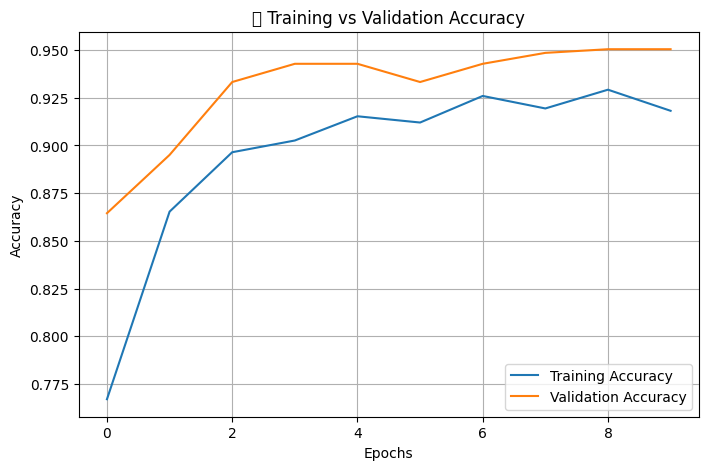

In [27]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("📈 Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
print("\n🧠 MODEL ARCHITECTURE SUMMARY")
print("-" * 40)
model.summary()



🧠 MODEL ARCHITECTURE SUMMARY
----------------------------------------


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         3,074 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,580,435 (116.66 MB)

 Trainable params: 9,896,912 (37.75 MB)

 Non-trainable params: 889,697 (3.39 MB)

 Optimizer params: 19,793,826 (75.51 MB)

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os

base_path = "/content/drive/MyDrive/Tilapia-Fish-Classifier"

folders = [
    "notebooks",
    "models",
    "app",
    "data/sample_images"
]

for f in folders:
    os.makedirs(os.path.join(base_path, f), exist_ok=True)

print("✅ Project folders created")


✅ Project folders created


In [32]:
!ls


drive  sample_data  tilapia_best_model.keras


In [33]:
!ls /content/drive/MyDrive


'10 12 Admit Photo.pdf'
'12022002018003_Aquasa Aziz'
 12022002018003.jpg
 4409601e-f7b1-492e-b05a-16b3cdef848e.jpg
'6_ Ifc'
'aadhar 18+.pdf'
'Aadhar Aafreen (1).pdf'
'Aadhar Aafreen.pdf'
'Aadhar Card Aquasa.pdf'
'Aafreen 10th (1).pdf'
'Aafreen 10th.pdf'
'Aafreen 12th (1).pdf'
'Aafreen 12th.pdf'
'aafreen (1).pdf'
 aafreen.pdf
'A AZIZ_merged.pdf'
'AdmitCard-210410403794 (1).pdf'
'Admit_Card_Clat_2024_155011277_655bddaa6c6af (1).pdf'
 Admit_Card_Clat_2024_155011277_655bddaa6c6af.pdf
'Adobe Scan 17-May-2024 (1).pdf'
 ai_analytics_agent
 AI-ML.gdoc
'Aquasa Aziz_12022002018003_ (1).pdf'
'Aquasa Aziz_12022002018003_ (2).pdf'
'Aquasa Aziz_12022002018003_ (3).pdf'
'Aquasa Aziz_12022002018003_.pdf'
'Aquasa Aziz (1).pdf'
'Aquasa Aziz CS.pdf'
'AQUASA AZIZ CV (1).pdf'
'AQUASA AZIZ CV.gdoc'
'Aquasa Aziz CV.pdf'
'AQUASA AZIZcv.pdf'
'AQUASA AZIZ CV.pdf'
'Aquasa Aziz CV with Photograph (1).pdf'
'Aquasa Aziz CV with Photograph (2).pdf'
'Aquasa Aziz CV with Photograph (3).pdf'
'Aquasa Aziz CV with Photog

In [ ]:
!find /content -name "Telapia_Non_Telapia.ipynb"


/content/drive/MyDrive/Colab Notebooks/Telapia_Non_Telapia.ipynb


In [ ]:
!cp "/content/drive/MyDrive/Colab_Notebooks/Telapia_Non_Telapia.ipynb" \
    "/content/drive/MyDrive/Tilapia-Fish-Classifier/notebooks/"